In [1]:
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup

import json
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import datasets

In [4]:
# fetch data
headers = {'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.149 Safari/537.36'}
req = Request('https://thevirustracker.com/timeline/map-data.json', headers=headers)
with urlopen(req) as res:
    data = json.load(res)

In [5]:
# obtain country mapping
# req = Request('https://thevirustracker.com/api',
#               headers=headers)
# with urlopen(req) as res:
#      html = res.read().decode('utf-8')
# soup = BeautifulSoup(html, 'html.parser')
# result = soup.find('tbody')
# country_map = {child.a.string[:2]: child.td.string for child in result.find_all('tr')}
# country_map['Others'] = 'Others'

mapping = {d['countrycode']: d['countryregion'] for d in data['matchup']}

In [6]:
df = pd.DataFrame(data['ashley new data'])
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y')
df.columns = ['Date', 'Country', 'Cases', 'Deaths', 'Recovered']
df.sort_values(['Country', 'Date'], inplace=True)
df.set_index(['Country', 'Date'] , inplace=True)
df = df.applymap(lambda i: int(i.replace(',', '')))
df

Cases  Deaths  Recovered
Country Date                                
AD      2020-03-03      1       0          0
        2020-03-03      1       0          0
        2020-03-04      1       0          0
        2020-03-05      1       0          0
        2020-03-06      1       0          0
...                   ...     ...        ...
ZW      2020-03-28      7       1          0
        2020-03-29      7       1          0
        2020-03-30      7       1          0
        2020-03-31      8       1          0
        2020-04-01      8       1          0

[5406 rows x 3 columns]

In [7]:
today = df.groupby('Country').last()
today_cases = today.sort_values('Cases', ascending=False)
today_deaths = today.sort_values('Deaths', ascending=False)
today_recovered = today.sort_values('Recovered', ascending=False)

In [8]:
# arugments for ploting
cases = [today_cases['Cases'], 'infections', 'Oranges']
deaths = [today_deaths['Deaths'], 'deaths', 'Reds']
recoverd = [today_recovered['Recovered'], 'recovered', 'Greens']

In [9]:
textprops = dict(fontsize='large', fontfamily='sans serif')
    
def top_countries_proportion(data, category, cmap, n=8):
    other = data[n:].sum()
    today_top = data[:n].append(pd.Series(data=other, index=['Others']))
    
    fig, ax = plt.subplots(figsize=(16, 6.6))
    explode = np.zeros(n+1)
    explode[:] = 0.03
    norm = mpl.colors.Normalize(vmin=today_top.min()/1.25, vmax=today_top.max()*1.25)
    colors = mpl.cm.get_cmap(cmap)(norm(today_top))
    patches, texts, autotexts = ax.pie(today_top, labels=today_top.index, pctdistance=0.7,
                                       explode=explode, autopct='%.1f%%', textprops=textprops,
                                       colors=colors)
    for t, p in zip(autotexts, patches):
        t.set_fontsize(10)
        if np.array(p.get_facecolor()).prod() < 0.1:
            t.set_color('w')
    ax.set_title('Global {} proportions'.format(category))
    plt.show()

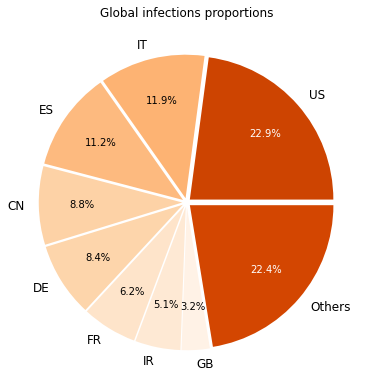

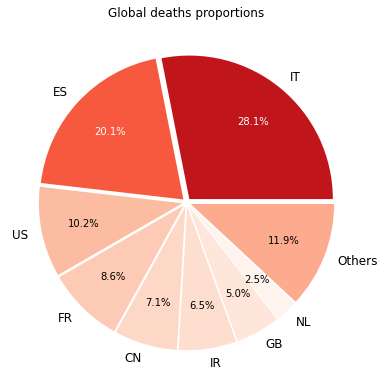

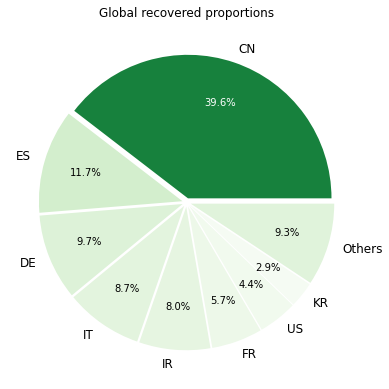

In [25]:
top_countries_proportion(*cases)
top_countries_proportion(*deaths)
top_countries_proportion(*recoverd)

In [13]:
font_dict = dict(fontsize='large', fontfamily='sans serif')

def label(rects, ax):
    for rect in rects:
        width = rect.get_width()
        height = rect.get_height()
        ax.annotate('{}'.format(width),
                    xy=(width, rect.get_y() + height / 2), xytext=(25, 0),
                    textcoords="offset points",ha='center', va='center')

def top_countries(data, category, cmap, n=20):
    data_top = data[:n]

    fig, ax = plt.subplots(figsize=(15, 10))
    color = mpl.cm.get_cmap(cmap)(mpl.colors.LogNorm(vmin=data_top.min()/1.5, vmax=data_top.max()*1.5)(data_top))
    rects = ax.barh(range(data_top.shape[0]), data_top, color=color)
    label(rects, ax)

    ax.set_xlabel('cases ($\\times10^3$)', font_dict)
    ax.set_xticklabels(ax.get_xticks() / 1e3, font_dict)
    ax.set_yticks(range(n))
    ax.set_yticklabels(data_top.index, font_dict)
    ax.invert_yaxis()
    ax.set_title('Countries with the most {}'.format(category), font_dict)
    ax.grid(True, axis='x')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.show()

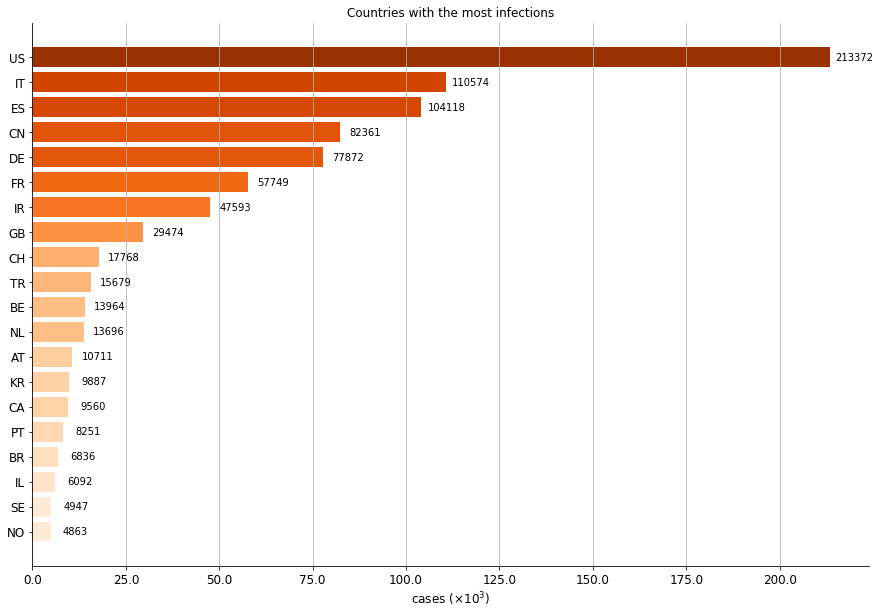

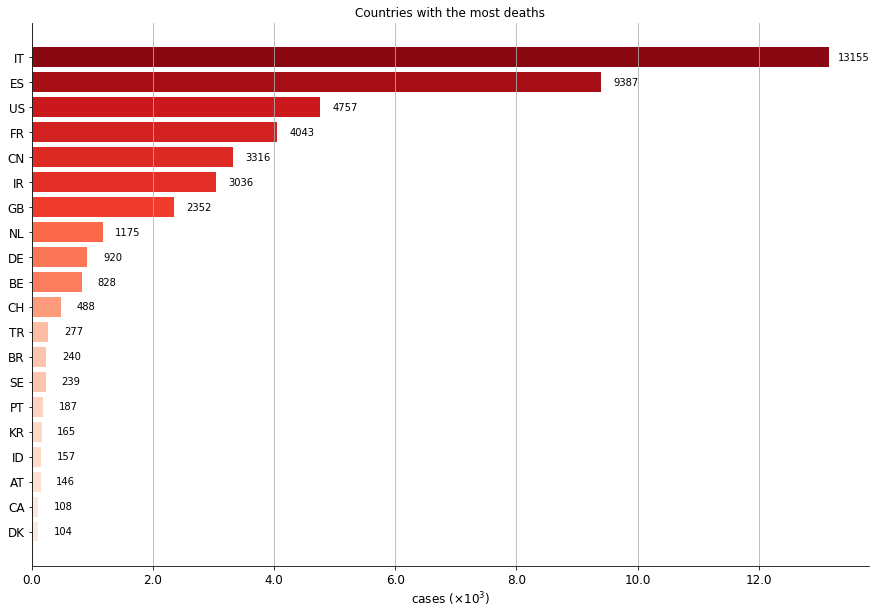

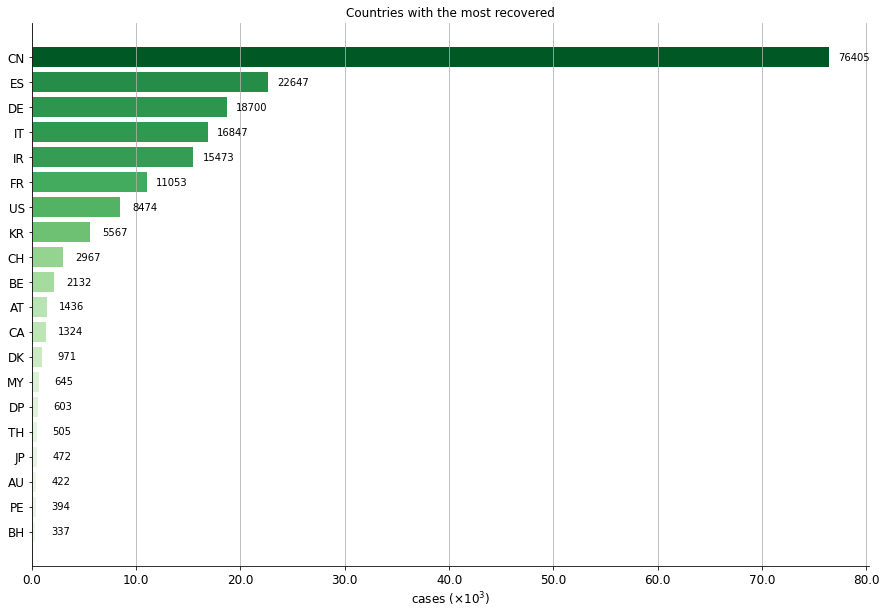

In [26]:
top_countries(*cases)
top_countries(*deaths)
top_countries(*recoverd)

In [22]:
colors = ['tab:orange', 'tab:red', 'tab:green']

def draw_timeline(countrycode):
    fig, ax = plt.subplots(figsize=(9, 6))
    data = df.loc[countrycode]
    c, d, r = np.squeeze(data.last('1D').values)
    for (label, content), color, i in zip(data.iteritems(), colors, [0, 0, 5 if (d-r)/(r++1e-10) <= 0.15 else -5]):
        ax.plot(content, label=label, color=color)
        ax.annotate(content[-1], xy=(ax.get_xticks()[-1], content[-1]),
                    xycoords=ax.transData, xytext=(0, i), textcoords='offset points',
                    va='center', ha='left', fontsize=8)
    ax.set_title('{} ({})'.format(mapping[countrycode], countrycode))
    ax.get_xaxis().set_major_formatter(mpl.dates.DateFormatter('%m-%d'))
    ax.grid()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend()
    plt.savefig(os.path.join('./country_timeline', '{}.png'.format(mapping[countrycode])))

In [24]:
for countrycode in today.index:
    draw_timeline(countrycode)
    plt.close()

In [ ]:
# fetch data
headers = {'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.149 Safari/537.36'}
req = Request('https://thevirustracker.com/free-api?countryTimeline=CN', headers=headers)
with urlopen(req) as res:
#     data = json.load(res)
    print(res.read())

In [ ]:
d = {}
for data in data['timelineitems']:
    d.update(data)
pd.DataFrame(d).T